# Imports

In [1]:
import cv2 as cv
import shutil
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import time
import requests
import zipfile

# Load the data

In [2]:
mypath = 'tsrd-train'


# check if file 'TsignRecgTrain4170Annotation.txt' exists

if os.path.isfile('TsignRecgTrain4170Annotation.txt'):
    print('File exists')

else :
    print('Downloading annotation file...')
    f_annotation = "http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Train%20Annotation.zip"
    r = requests.get(f_annotation, stream=True)
    
    with open("TSRD-Train Annotation.zip", "wb") as f: shutil.copyfileobj(r.raw, f)
    with zipfile.ZipFile("tsrd-train Annotation.zip","r") as zip_ref: zip_ref.extractall(".")
    print("Downloaded annotation file\n")
    


# check if folder 'tsrd-train' exists
            
if os.path.exists(mypath):
    print('Directory exists')
    # check if file contains 4170 images
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    if len(onlyfiles) >= 4170:
        print('Directory contains 4170 images')
    else :
        print('Downloading images...')
        f_images = "http://www.nlpr.ia.ac.cn/pal/trafficdata/tsrd-train.zip"
        r = requests.get(f_image, stream=True)
        with open("tsrd-train.zip", "wb") as f: shutil.copyfileobj(r.raw, f)
        with zipfile.ZipFile("tsrd-train.zip","r") as zip_ref: zip_ref.extractall("./tsrd-train")
        print("Downloaded image file")



File exists
Directory exists
Directory contains 4170 images


In [3]:
# read annotation file

annotation = 'TsignRecgTrain4170Annotation.txt'

header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
data = pd.read_csv(annotation, sep=';', header=None, index_col=False, names=header)

data.head()


,filename,width,height,x1,y1,x2,y2,class
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


In [4]:
# print number of images

print('Number of images: ', len(data))
print('Number of classes: ', len(data['class'].unique()))

Number of images:  4170
Number of classes:  58


Text(0, 0.5, 'Count')

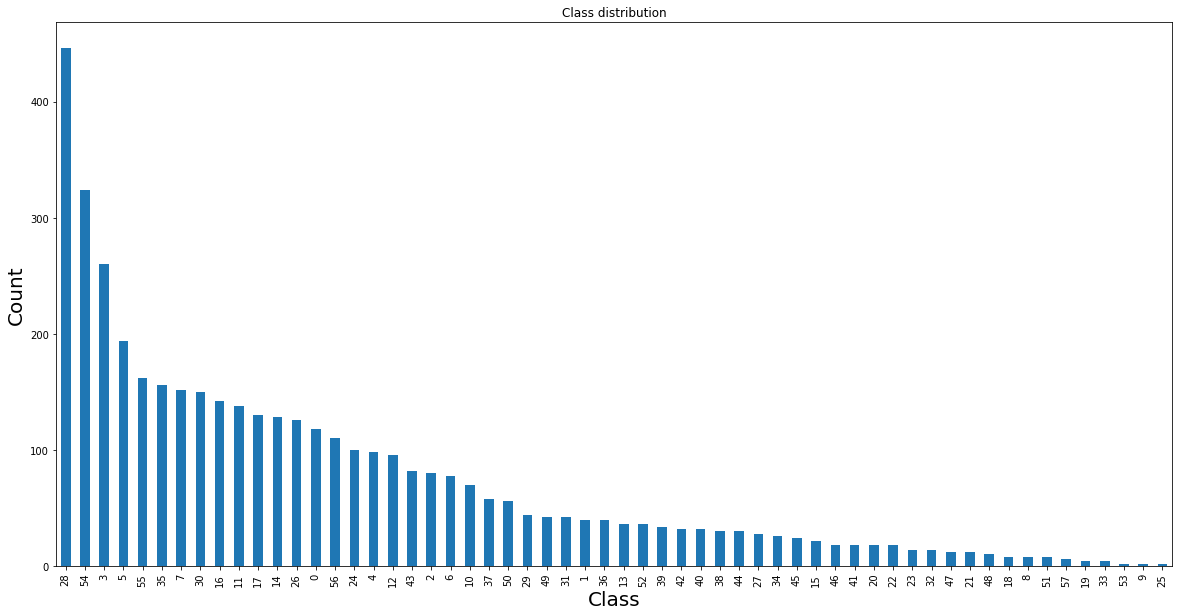

In [5]:
# plot class distribution

data['class'].value_counts().plot(kind='bar', figsize=(20,10))
plt.title('Class distribution')
plt.rcParams.update({'font.size': 20})
plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20)


# Load image

idx = 2167


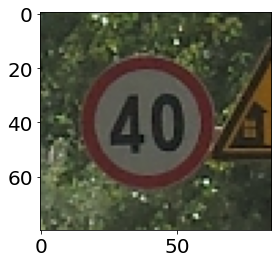

In [6]:
mypath = 'tsrd-train'

def load_image(idx=None, filename=None):
    """
    This function will help you to load an image from the dataset based on  filename or idx as index.
    if `idx` and `filename` are both None, a random image will be loaded.
    """
    
    if filename is None:
        idx = np.random.randint(0, len(data) - 1) if idx is None else idx
    else:
        idx = data[data['filename'] == filename].index[0]
    
    img = cv.imread(join(mypath, data.iloc[idx]['filename']))
    
    return img, idx

img, idx = load_image()
print(f'idx = {idx}')

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
# plt.title(f"idx = {idx} class = {data.iloc[idx]['class']}")
plt.rcParams.update({'figure.figsize':(5,5)})
plt.show()

# Preprocess image

### Pre-defined functions

In [7]:
# Pre-defined function to plot image

def plot(img, title=None, img2=None, title2=None):
    
    if img2 is None:
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.Axes.set_axis_off(plt.gca())
    else:
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title(title)
        ax[1].imshow(img2, cmap='gray')
        ax[1].set_title(title2)
        ax[0].set_axis_off()
        ax[1].set_axis_off()
    
    plt.show()
    
def remove_small_blob(mask):
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv.contourArea(cnt) < 12000:
            cv.drawContours(mask, [cnt], 0, 0, -1)
    return mask

def floodFill(mask):
    im_th = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv.floodFill(im_floodfill, mask, (0, 0), 255)
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    mask = im_th | im_floodfill_inv
    return mask
    

## Preprocessing

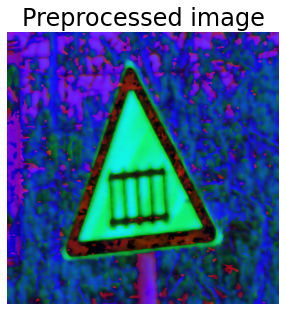

In [8]:
def preproccessing(image):
    # resize image to 500x500
    image = cv.resize(image, (500, 500))
    
    # convert image to HSV
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    # split HSV channels into H, S, V
    h, s, v = cv.split(hsv)
    
    # apply Histogram Equalization to V channel
    v = cv.equalizeHist(v)
    
    # merge H, S, V channels
    hsv = cv.merge((h, s, v))
    
    # Image blurring using median blur
    hsv = cv.medianBlur(hsv, 3)
    
    # Image smoothing using Bilateral Filter
    hsv = cv.bilateralFilter(hsv, 9, 75, 75)
    return hsv

plot(preproccessing(load_image()[0]), 'Preprocessed image')

## Thresholding by Red, Blue, Yellow 
### (Most common traffic signs colors)

idx = 1437


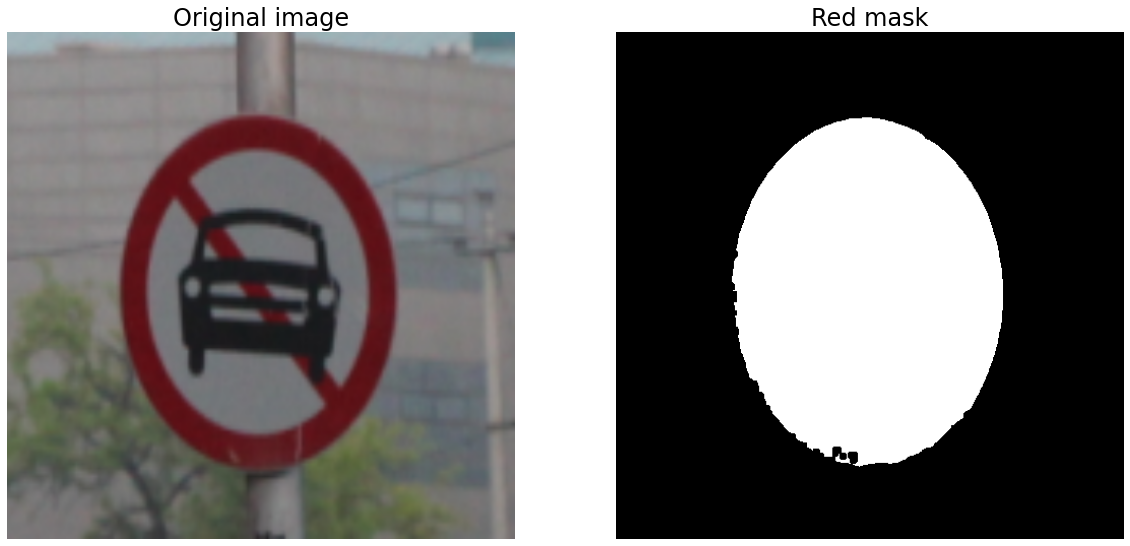

In [9]:
def red_mask(hsv):
    low_lower_red, low_upper_red = np.array([0, 120, 0]), np.array([7, 255, 255])

    high_lower_red, high_upper_red = np.array([160, 100, 0]), np.array([180, 255, 255])

    mask = cv.inRange(hsv, low_lower_red, low_upper_red) + cv.inRange(hsv, high_lower_red, high_upper_red)
    mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    
    kernel = np.ones((3, 3), np.uint8)
    mask = cv.erode(mask, np.ones((5, 5), np.uint8), iterations=1)

    mask = floodFill(remove_small_blob(mask))
    return mask
    
img, idx = load_image(1437)
print(f'idx = {idx}')

hsv = preproccessing(img)
rgb = cv.cvtColor(cv.resize(img, (500, 500)), cv.COLOR_BGR2RGB)

plot(rgb, img2=red_mask(hsv) , title='Original image', title2='Red mask')

idx = 1548


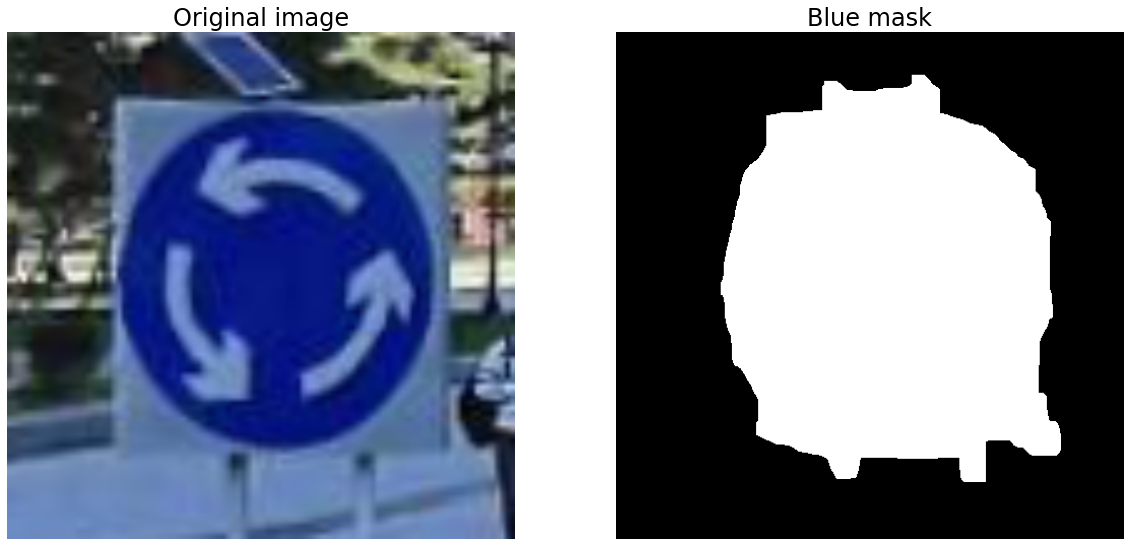

In [10]:
def blue_mask(hsv):
    lower_blue, upper_blue = np.array([79, 120, 0]), np.array([140, 255, 255])
    
    mask = cv.inRange(hsv, lower_blue, upper_blue)
    mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

    kernel = np.ones((3, 3), np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=3)
    
    mask = remove_small_blob(mask)
    mask = cv.morphologyEx(mask, cv.MORPH_DILATE, kernel, iterations=3)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=10)
    
    mask = remove_small_blob(floodFill(mask))
    
    return mask

img, idx = load_image(1548)
print(f'idx = {idx}')

hsv = preproccessing(img)
rgb = cv.cvtColor(cv.resize(img, (500, 500)), cv.COLOR_BGR2RGB)

plot(rgb, img2=blue_mask(hsv) , title='Original image', title2='Blue mask')

idx = 2964


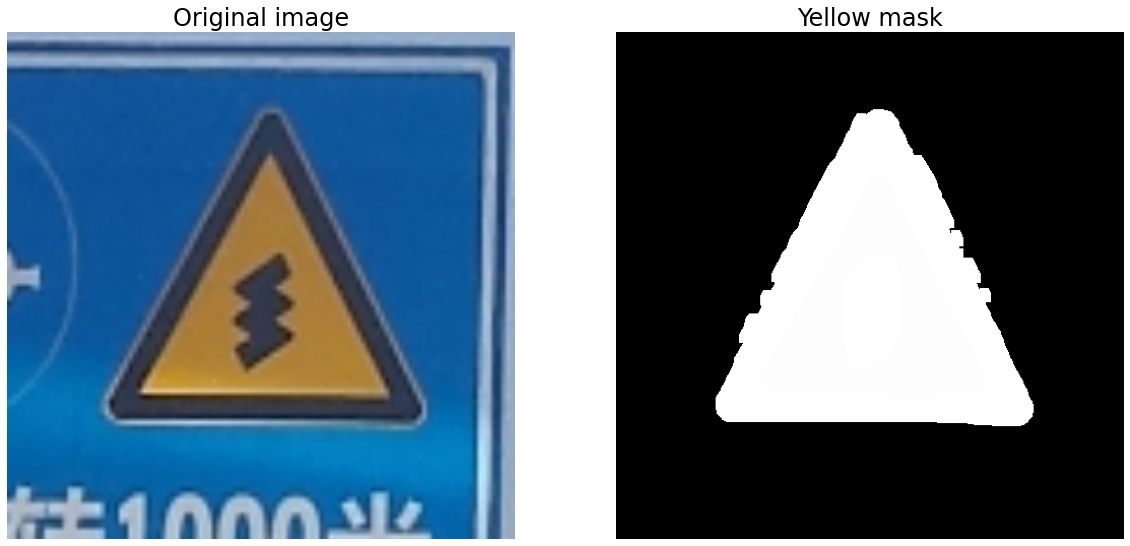

In [11]:
def yellow_mask(hsv):
    
    def black_mask(hsv):
        lower_black, upper_black = np.array([0, 20, 0]), np.array([180, 255, 45])
        
        mask = cv.inRange(hsv, lower_black, upper_black)
        mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
        mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=2)
        mask = floodFill(remove_small_blob(mask))
        
        return cv.morphologyEx(mask, cv.MORPH_ERODE, np.ones((3, 3), np.uint8), iterations=2)
    
    
    lower_yellow, upper_yellow = np.array([10, 120, 20]), np.array([50, 255, 255])
    yellow_mask = cv.inRange(hsv, lower_yellow, upper_yellow)
    yellow_mask = cv.morphologyEx(yellow_mask, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=4)
    yellow_mask = remove_small_blob(yellow_mask)
    
    yellow_copy = yellow_mask.copy()
    yellow_copy = cv.erode(yellow_copy, np.ones((5, 5), np.uint8), iterations=2)
    yellow_copy = cv.morphologyEx(yellow_copy, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=2)
    yellow_copy = cv.dilate(yellow_copy, np.ones((3, 3), np.uint8), iterations=5)
    yellow_copy = cv.morphologyEx(yellow_copy, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=10)
    
    yellow_mask = yellow_mask + yellow_copy
    yellow_mask = remove_small_blob(yellow_mask)
    
    black_mask = black_mask(hsv)
    black_mask = cv.morphologyEx(black_mask, cv.MORPH_DILATE, np.ones((3, 3), np.uint8), iterations=4)

    return yellow_mask + black_mask

    
img, idx = load_image(2964)
print(f'idx = {idx}')

hsv = preproccessing(img)
rgb = cv.cvtColor(cv.resize(img, (500, 500)), cv.COLOR_BGR2RGB)

plot(rgb, img2=yellow_mask(hsv) , title='Original image', title2='Yellow mask')

idx = 3135


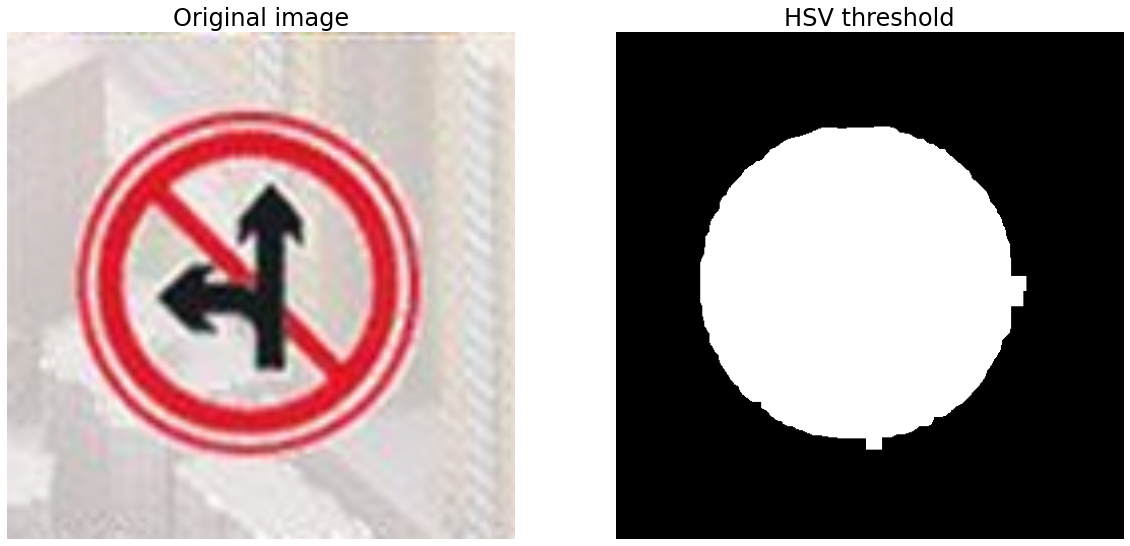

In [12]:
def hsv_threshold(hsv):
    h, s, v = cv.split(hsv)
    
    _, h_thresh = cv.threshold(h, 0, 180, cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, s_thresh = cv.threshold(s, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, v_thresh = cv.threshold(v, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    h_thresh = floodFill(cv.bitwise_not(h_thresh))
    h_thresh = remove_small_blob(h_thresh)
    
    s_thresh = floodFill(s_thresh)
    s_thresh = cv.morphologyEx(s_thresh, cv.MORPH_ERODE, np.ones((3, 3), np.uint8), iterations=10)
    s_thresh = remove_small_blob(s_thresh)

    thresh = h_thresh * s_thresh
    thresh = cv.bitwise_and(thresh, cv.bitwise_not(v_thresh))
    thresh = cv.morphologyEx(thresh, cv.MORPH_DILATE, np.ones((5, 5), np.uint8), iterations=4)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=2)
    thresh = cv.morphologyEx(thresh, cv.MORPH_ERODE, np.ones((3, 3), np.uint8), iterations=2) 
    thresh = floodFill(remove_small_blob(thresh))
    return thresh

img, idx = load_image(3135)
print(f'idx = {idx}')

hsv = preproccessing(img)
rgb = cv.cvtColor(cv.resize(img, (500, 500)), cv.COLOR_BGR2RGB)

plot(rgb, img2=hsv_threshold(hsv) , title='Original image', title2='HSV threshold')

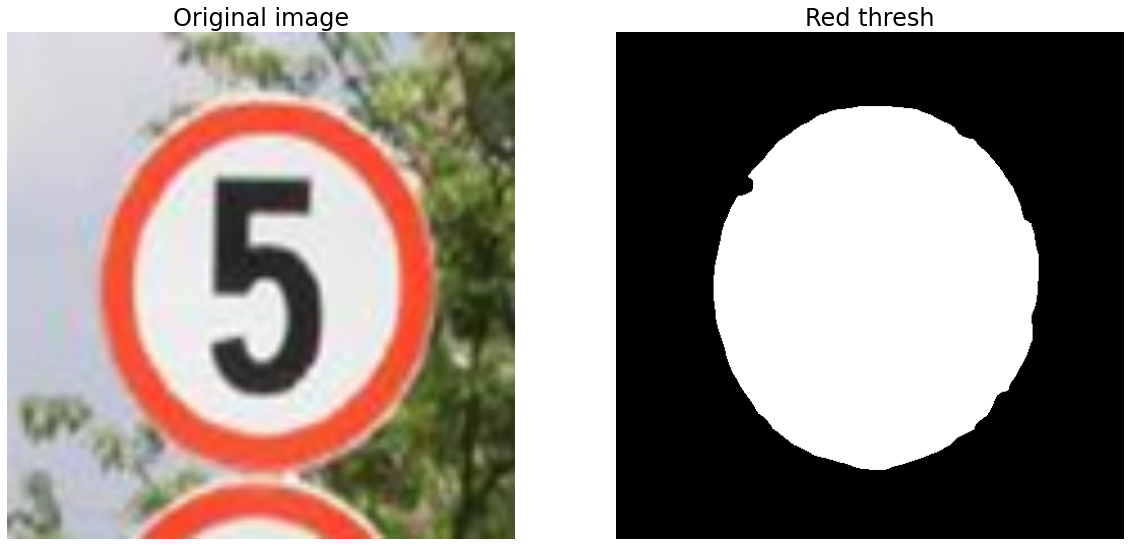

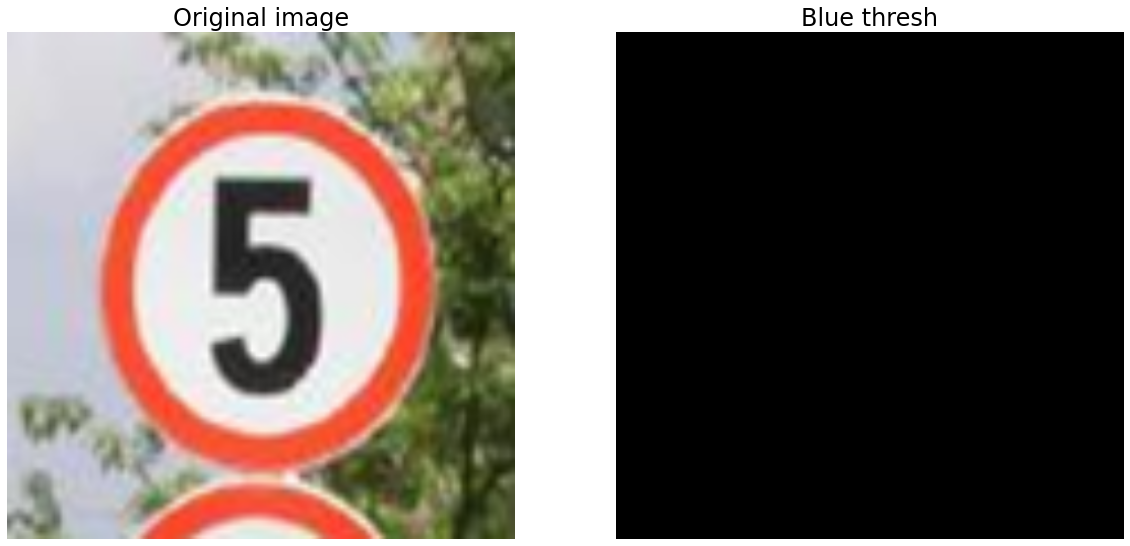

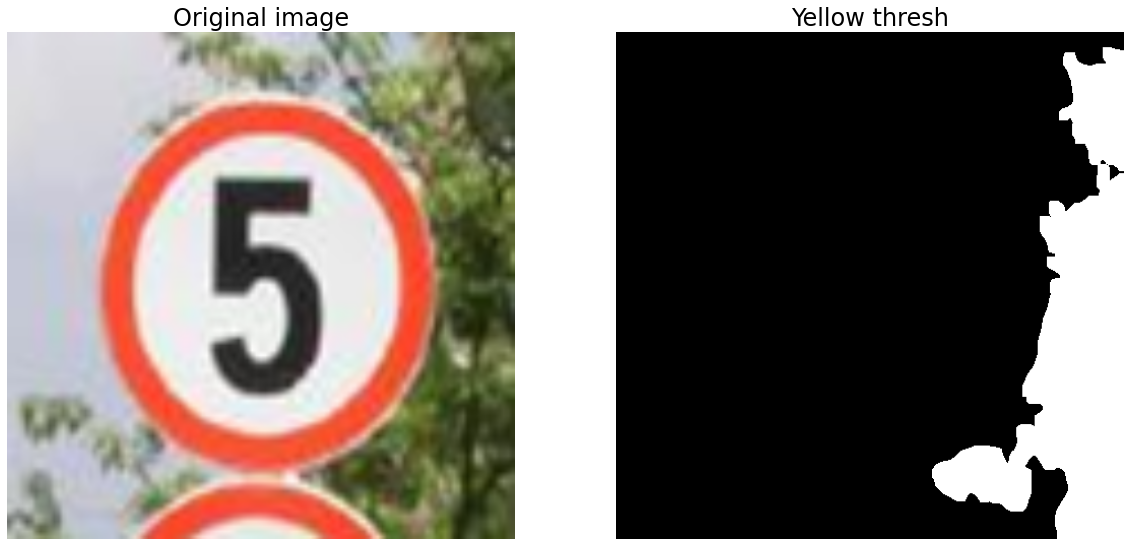

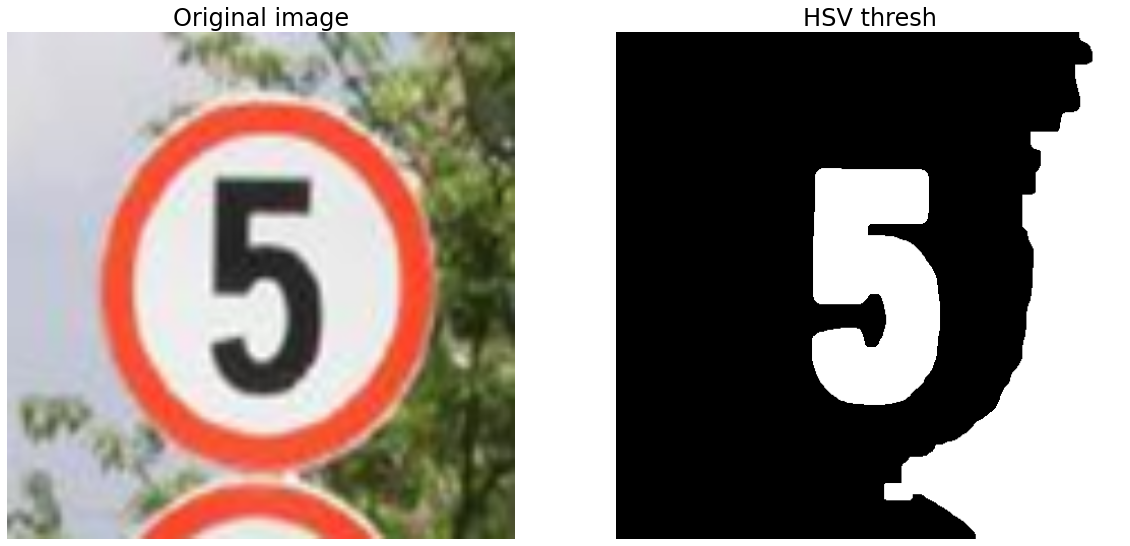

In [13]:
threshs = lambda hsv: [red_mask(hsv), blue_mask(hsv), yellow_mask(hsv), hsv_threshold(hsv)]
labels = ['Red thresh', 'Blue thresh', 'Yellow thresh', 'HSV thresh']


img, idx = load_image()

hsv = preproccessing(img)
rgb = cv.cvtColor(cv.resize(img, (500, 500)), cv.COLOR_BGR2RGB)

for thresh, label in zip(threshs(hsv), labels):
    plot(rgb, img2=thresh, title='Original image', title2=label)

# Segmenting

Number of contours = 4
Number of contours in Red thresh = 1
Number of contours in Blue thresh = 0
Number of contours in Yellow thresh = 0
Number of contours in HSV thresh = 1


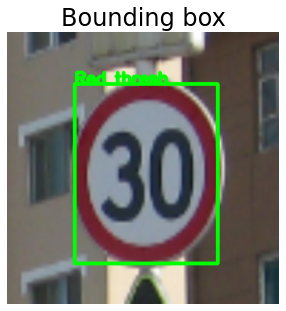

In [14]:
def get_contour(thresh):
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    return contours

threshs_contours = [get_contour(thresh) for thresh in threshs(preproccessing(load_image(2139)[0]))]

def compare_and_choose_contour(threshs_contours, verbose=False):
    
    if verbose:
        print(f'Number of contours = {len(threshs_contours)}')
        for i in range(len(threshs_contours)): print(f'Number of contours in {labels[i]} = {len(threshs_contours[i])}')

    contours = {label: threshs_contours[i] for i, label in enumerate(labels)}

    # each thresh with its own color
    colors = [(0, 0, 255), (255, 0, 0), (0, 255, 255), (255, 255, 255)]

    lbs = []
    cnts = []
    count = 0
    width, height = 500, 500

    for i, (label, contour) in enumerate(contours.items()):
        
        for cnt in contour:
            area = cv.contourArea(cnt)
            x, y, w, h = cv.boundingRect(cnt)
            if w!=width and h!=height and x>0 and y>0 and w>20 and h>20 and area>1000:
                cnts.append([cnt, label])
                count += 1


    if count == 0 or cnts == []:
        print('No bounding box found') if verbose else None
        return None
    else:
        largest_contour = max(cnts, key=lambda x: cv.contourArea(x[0]))[0]
        largest_label = max(cnts, key=lambda x: cv.contourArea(x[0]))[1]
        x, y, w, h = cv.boundingRect(largest_contour)
        return [x, y, w, h, largest_label]


img, idx = load_image(2139)
img = cv.resize(img, (500, 500))
hsv = preproccessing(img)

contour = compare_and_choose_contour([get_contour(thresh) for thresh in threshs(preproccessing(load_image(2139)[0]))], True)

if contour is not None:
    x, y, w, h, label = contour
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    cv.rectangle(rgb, (x, y), (x + w, y + h), (0, 255, 0), 5)
    cv.putText(rgb, label, (x, y), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 5)
    plot(rgb, title='Bounding box')

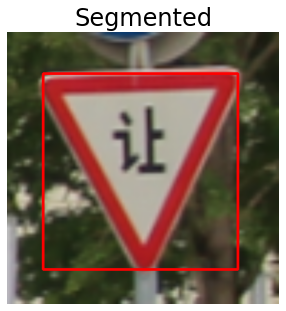

In [59]:
def segmentation(img):
    rgb = cv.cvtColor(cv.resize(img, (500, 500)).copy(), cv.COLOR_BGR2RGB)
    img = preproccessing(img)
    contours = [get_contour(thresh) for thresh in threshs(img)]
    
    x, y, w, h, label = compare_and_choose_contour(contours) if compare_and_choose_contour(contours) is not None else [0, 0, 0, 0, '']
    rgb = cv.rectangle(rgb, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return [x, y, w, h], rgb


img, idx = load_image()

predBox, pred = segmentation(img)

plot(pred, title='Segmented')

# Evaluation

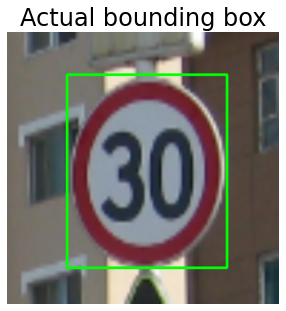

In [18]:
def actual_box(idx):
    img = load_image(idx)[0]
    height, width = img.shape[:2]
    x, y, w, h = data.iloc[idx]['x1'], data.iloc[idx]['y1'], data.iloc[idx]['x2'] - data.iloc[idx]['x1'], data.iloc[idx]['y2'] - data.iloc[idx]['y1']
    x, w = int(x * 500 / width), int(w * 500 / width)
    y, h = int(y * 500 / height), int(h * 500 / height)
    
    img = cv.resize(img, (500, 500))
    img = cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 4)
    return [x, y, w, h], img

_, img = actual_box(load_image(2139)[1])
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB), title='Actual bounding box')

Image 69 accuracy: 81.08%	average accuracy: 86.93%[███████████████████ ] 98%
Average accuracy: 86.92649106623837%
Average time taken: 28.101536285714293 ms


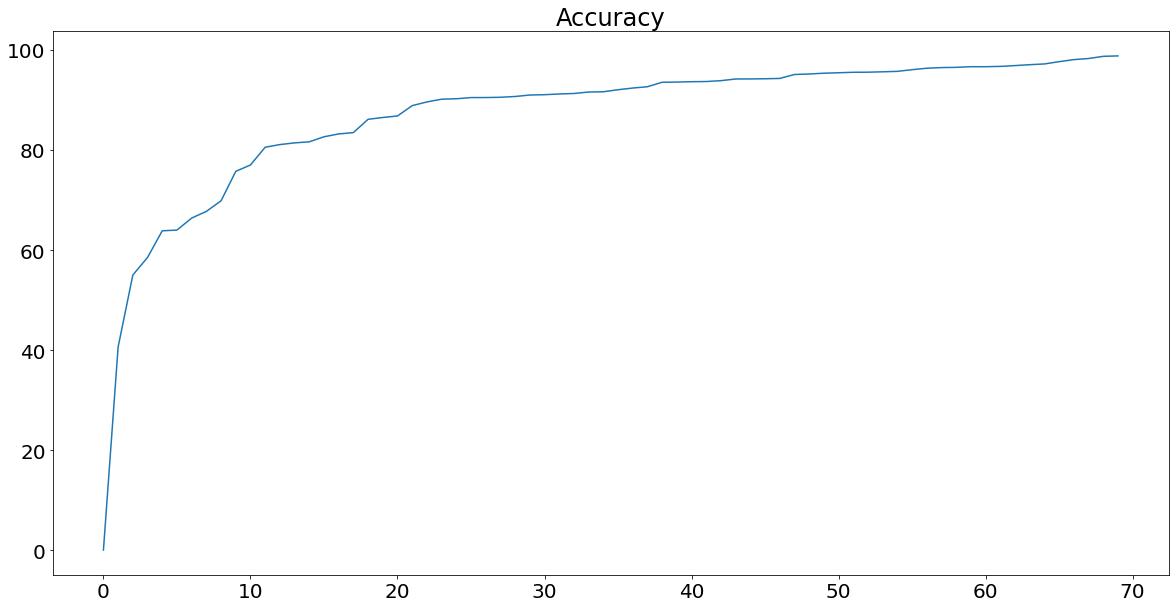

In [19]:
def intersection_over_union(pred, actual):
    x1, y1, w1, h1 = pred
    x2, y2, w2, h2 = actual
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (w1 + 1) * (h1 + 1)
    boxBArea = (w2 + 1) * (h2 + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou * 100

def accuracy(data, test=False):
    acc = []
    time_ms = []
    if test:
        # load all filename of images in test folder
        test_path = "test/"
        filename = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

        test_acc = []
        for i in range(len(filename)):
            start = time.perf_counter()
            img, idx = load_image(filename=filename[i])
            pred = segmentation(img)[0]
            time_ms.append((time.perf_counter() - start)*1000)
            actual = actual_box(idx)[0]
            iou = intersection_over_union(pred, actual)
            acc.append(iou)
            sys.stdout.write('\r')
            sys.stdout.write('Image {} accuracy: {:.2f}%\taverage accuracy: {:.2f}%'.format(i, iou, np.mean(acc)))
            sys.stdout.write("[%-20s] %d%%" % ('█'*int(i/len(filename)*20), 100*i/len(filename)))
            sys.stdout.flush()
        print(f'\nAverage accuracy: {np.mean(acc)}%')
        print(f'Average time taken: {np.mean(time_ms)} ms')
        return acc, time_ms
    else:
        for i in range(len(data)):
            start = time.perf_counter()
            img, idx = load_image(i)
            pred = segmentation(img)[0]
            time_ms.append((time.perf_counter() - start)*1000)
            actual = actual_box(idx)[0]
            iou = intersection_over_union(pred, actual)
            acc.append(iou)
            sys.stdout.write('\r')
            sys.stdout.write('Image {} accuracy: {:.2f}%\taverage accuracy: {:.2f}%'.format(i, iou, np.mean(acc)))
            sys.stdout.write("[%-20s] %d%%" % ('█'*int(i/len(data)*20), 100*i/len(data)))
            sys.stdout.flush()
        print(f'\nAverage accuracy: {np.mean(acc)}%')
        return acc, time_ms
    
def plot_acc(acc, title='Accuracy'):
    plt.figure(figsize=(20, 10))
    plt.title(title)
    plt.plot(np.sort(acc))
    plt.show()

acc, time_ms = accuracy(data, test=True)
plot_acc(acc, title='Accuracy')